In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from random import randrange, uniform

In [2]:
#Set The Current working directory
os.chdir("C:/Users/Lenovo/Documents/LM/EdWisor/Python")

In [3]:
os.getcwd()

'C:\\Users\\Lenovo\\Documents\\LM\\EdWisor\\Python'

In [4]:
# Load Data - Train Data
Train_Data=(pd.read_csv('train_cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [5]:
#Eliminate rows where the pickup and drop location points are same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]

In [6]:
#replace 0 with NA in the variables and convert the data wherever required for further operations

Train_Data['fare_amount']= Train_Data['fare_amount'].apply(pd.to_numeric, errors='coerce')
Train_Data['fare_amount']= Train_Data['fare_amount'].replace({0:np.nan})
Train_Data['passenger_count']=Train_Data['passenger_count'].fillna(0)
Train_Data['passenger_count']= Train_Data['passenger_count'].astype(int)
Train_Data['passenger_count']=Train_Data['passenger_count'].replace({0: np.nan})
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].replace({0:np.nan})
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].replace({0:np.nan})
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].replace({0:np.nan})
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].replace({0:np.nan})

In [7]:
Train_Data.shape

(15603, 6)

In [8]:
Train_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0


# Missing Value Analysis

In [9]:
#calculate missing values

missing_val = pd.DataFrame(Train_Data.isnull().sum())
#print(missing_val)

#Reset index
missing_val = missing_val.reset_index()
#print(missing_val)

#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'count'})
#print(missing_val)

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['count']/len(Train_Data)*100)
#print(missing_val)

#sort in descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
print(missing_val)
    

           Variables  count  Missing_percentage
0    passenger_count    112            0.717811
1        fare_amount     24            0.153817
2   pickup_longitude     12            0.076908
3    pickup_latitude     12            0.076908
4  dropoff_longitude     10            0.064090
5   dropoff_latitude      9            0.057681


# Missing Value Imputation

In [10]:
#imputation method 
#Actual value = -73.99578100000001
#Mean = -73.91159336554888
#Median = -73.9820605
#KNN = -73.890529

In [11]:
#Create missing value, a small test to identify which method is good for imputation

Train_Data["pickup_longitude"].loc[70]

-73.99578100000001

In [12]:
Train_Data["pickup_longitude"].loc[70] = np.nan

In [13]:
Train_Data["pickup_longitude"].loc[70]

nan

In [14]:
#Mean Imputation
#Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())

#Train_Data["pickup_longitude"].loc[70]

In [15]:
#Median Imputation
#Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].median())

#Train_Data["pickup_longitude"].loc[70]

In [16]:
#KNN imputation
#Train_Data = pd.DataFrame(KNN(k = 1).fit_transform(Train_Data), columns = Train_Data.columns)

#Train_Data["pickup_longitude"].loc[70]

In [17]:
#As it is found Mean is very close to original method we will proceed with imputation via mean
Train_Data['fare_amount'] = Train_Data['fare_amount'].fillna(Train_Data['fare_amount'].mean())
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())


#And for category variables imputation is done with mode
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [18]:
#Imputing the NAs in target variables may hamper the model, so it is preferred to remove NA rows of the data
Train_Data=Train_Data.dropna()

In [19]:
#conert into proper data type
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
Train_Data=Train_Data.astype(convert_dic)

In [20]:
Train_Data.shape

(15603, 6)

# Outlier Analysis

In [21]:
#save the data with in another place with different name

df = Train_Data.copy()
Train_Data = Train_Data.copy()


In [22]:
# irregular fare_amount are converted to NA 

Train_Data.loc[Train_Data['fare_amount']<0 , 'fare_amount']=np.nan
Train_Data.loc[Train_Data['fare_amount'] > 30, 'fare_amount']=np.nan
Train_Data=Train_Data.dropna()

In [23]:
#irregular passenger counts or those wgich are greater then 8 convertet to NaN
Train_Data.loc[Train_Data['passenger_count'] > 8,'passenger_count'] = np.nan

In [27]:
#save numeric data names
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(Train_Data[list], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
   
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    Train_Data.loc[Train_Data[list] < minimum,list] = np.nan
    Train_Data.loc[Train_Data[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(Train_Data.isnull().sum())
    


In [28]:
#As Mean is the best method, we impute missing values/ in this case outlier values with mean

Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude'] = Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude'] = Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude'] = Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())

#imputed with mode for categorical variables
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [29]:
#convert the data type of categorical variable passenger count
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('int')
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('category')

# Feature Selection

In [30]:
#haversine function

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [31]:
Train_Data['dist'] = \
    haversine( Train_Data['pickup_latitude'], Train_Data['pickup_longitude'],
                Train_Data['dropoff_latitude'], Train_Data['dropoff_longitude'])

In [32]:
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
Train_Data_corr = Train_Data.loc[:,numeric]


                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.049298        -0.057861   
pickup_longitude     -0.049298          1.000000         0.665421   
pickup_latitude      -0.057861          0.665421         1.000000   
dropoff_longitude     0.047996          0.356362         0.293342   
dropoff_latitude     -0.077377          0.314367         0.442597   
dist                  0.667880         -0.050237        -0.079968   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.047996         -0.077377  0.667880  
pickup_longitude            0.356362          0.314367 -0.050237  
pickup_latitude             0.293342          0.442597 -0.079968  
dropoff_longitude           1.000000          0.595164  0.067924  
dropoff_latitude            0.595164          1.000000 -0.060560  
dist                        0.067924         -0.060560  1.000000  


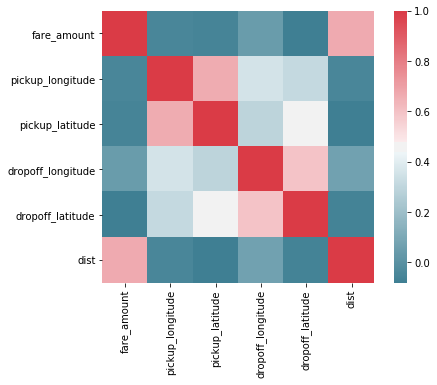

In [33]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = Train_Data_corr.corr()
print(corr)

#Plotted using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [35]:
#eliminate all data with the pickup and drop location points as same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]

# Model Development

# Decision Tree

In [36]:
#Load libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [37]:
# Divide the data into train and test
train1, test1 = train_test_split(Train_Data, test_size=0.2)


In [38]:
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [39]:
fit_DT

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [40]:
#Apply model on test data
predictions_DT = fit_DT.predict(test1.iloc[:,1:7])


In [41]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [42]:
MAPE(test1.iloc[:,0], predictions_DT)


28.774663291429192

In [43]:
#Error 28.774663291429192
#Accuracy 71.23

# Random Forest

In [44]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor



In [45]:
RF_model = RandomForestRegressor(n_estimators = 10).fit(train1.iloc[:, 1:7], train1.iloc[:,0])


In [46]:
RF_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
RF_Predictions = RF_model.predict(test1.iloc[:, 1:7])

In [48]:
MAPE(test1.iloc[:,0], RF_Predictions)

25.131668346501414

In [49]:
#error 25.131668346501414
#accuracy 74.87

# Linear Regression

In [50]:
#Combine all the values in one array
values=['fare_amount', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist']


In [51]:
linear_Data = Train_Data[values]


In [52]:
#This function is developed to get columns for specific passenger count. The idea is developed from R linear regression fit, 
#which explains all the passenger count individualy contributes in the model 

cat_names = ['passenger_count'] 
for i in cat_names:
    temp = pd.get_dummies(Train_Data[i], prefix= i)
    linear_Data = linear_Data.join(temp)

In [53]:
linear_Data.shape

(14795, 12)

In [54]:
linear_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
0,4.5,-73.981697,40.721319,-73.980230,40.712278,1.012886,1,0,0,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134,1,0,0,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525,0,1,0,0,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270,1,0,0,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157,1,0,0,0,0,0


In [55]:
#Spliting the newly created data set with passenger count dummies
train1, test1 = train_test_split(linear_Data, test_size=0.2)

In [56]:
#Import libraries for LR
import statsmodels.api as sm

In [57]:
# Train the model using the training sets
model = sm.OLS(train1.iloc[:, 0].astype(float), train1.iloc[:, 1:12].astype(float)).fit()

In [58]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     971.0
Date:                Thu, 11 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:20:51   Log-Likelihood:                -32642.
No. Observations:               11836   AIC:                         6.531e+04
Df Residuals:                   11825   BIC:                         6.539e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude     -8.1153      3.056     -2.655      0.008     -14.106      -2.124
pickup_latitude       6.9690      2.345      2.972      0.003       2.372      11.566
dropoff_longitude    14.7490      2.685      5.492      0.000       9.485      20.013
dropoff_latitude    -16.4963      2.107     -7.828      0.000     -20.627     -12.366
dist                  1.9859      0.021     95.766      0.000       1.945       2.027
passenger_count_1   883.5936    341.928      2.584      0.010     213.358    1553.830
passenger_count_2   883.7456    341.930      2.585      0.010     213.506    1553.985
passenger_count_3   883.8646    341.934      2.585      0.010     213.618    1554.111
passenger_count_4   883.8406    341.933      2.585      0.010     213.597    1554.085
passenger_count_5   883.5124    341.928      2.584      0.010     213.277    1553.748
passenger_count_6   884.8060    341.929      2.588      0.010     214.569    1555.043
==============================================================================
Omnibus:                     5963.342   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45147.146
Skew:                           2.313   Prob(JB):                         0.00
Kurtosis:                      11.375   Cond. No.                     2.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# make the predictions by the model
predictions_LR = model.predict(test1.iloc[:,1:12])


In [60]:
#Calculate MAPE
MAPE(test1.iloc[:,0], predictions_LR)

27.431370940383022

In [61]:
#Error 27.431370940383022
#Accuracy 72.56

# KNN Imputation

In [62]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train1.iloc[: , 1:7], train1.iloc[:, 0])



In [63]:
#predict test cases
KNN_Predictions = KNN_model.predict(test1.iloc[: , 1:7])


In [64]:
MAPE(test1.iloc[:,0], KNN_Predictions)

34.21410560965663

In [65]:
#error is 34.21410560965663
#accuracy is 65.80

# Prediction on original test data

In [66]:
pred=(pd.read_csv('test.csv', header = 0 )).drop(columns="pickup_datetime")

In [67]:
#create Dist variable
pred['dist'] = \
    haversine( pred['pickup_latitude'], pred['pickup_longitude'],
                 pred['dropoff_latitude'], pred['dropoff_longitude'])

pred['fare_amount']=0
pred['passenger_count']=pred['passenger_count'].astype('category')

In [68]:
# Build model on the entire Train data
RF_model = RandomForestRegressor(n_estimators = 10).fit(Train_Data.iloc[:, 1:7], Train_Data.iloc[:,0])

#predict value
pred['fare_amount'] = RF_model.predict(pred.iloc[:, 0:6])

In [69]:
pred.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323259,10.51
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,8.43
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,5.72
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,7.58
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,14.54


In [70]:
#write output to csv

pred.to_csv("Predicted_Values.csv", index = False)